LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


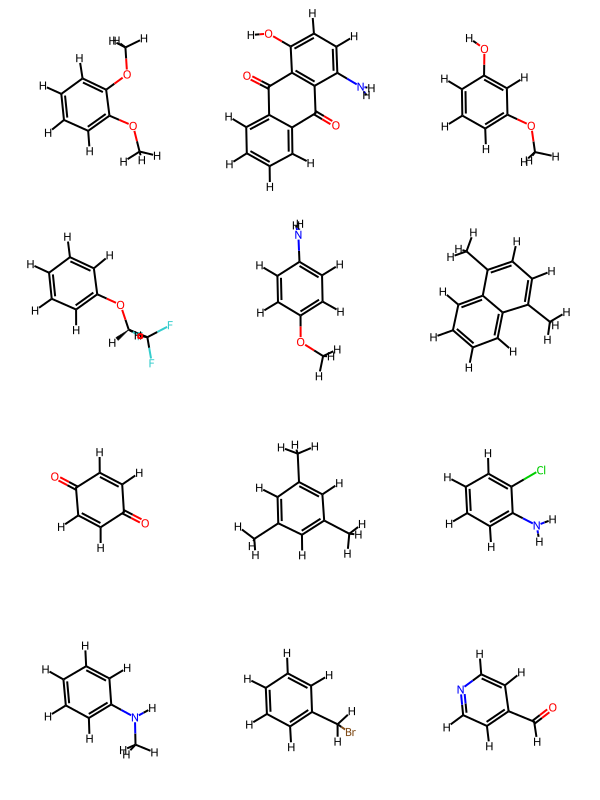

In [1]:
import numpy as np
from rdkit import Chem
from openfe_benchmarks import benzenes
from kartograf import KartografAtomMapper
from konnektor.visualization import draw_ligand_network
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score

system=benzenes.get_system()
compounds = system.ligand_components
compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"], compounds))
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

# Radial Network Layout

In [2]:
from konnektor.network_planners import RadialLigandNetworkPlanner
ligand_network_planner = RadialLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [3]:
radial_network = ligand_network_planner(compounds)
radial_network.name="Radial"
radial_network

/home/bries/programs/miniconda3/envs/openfe/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/tmp/ipykernel_25941/360503311.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


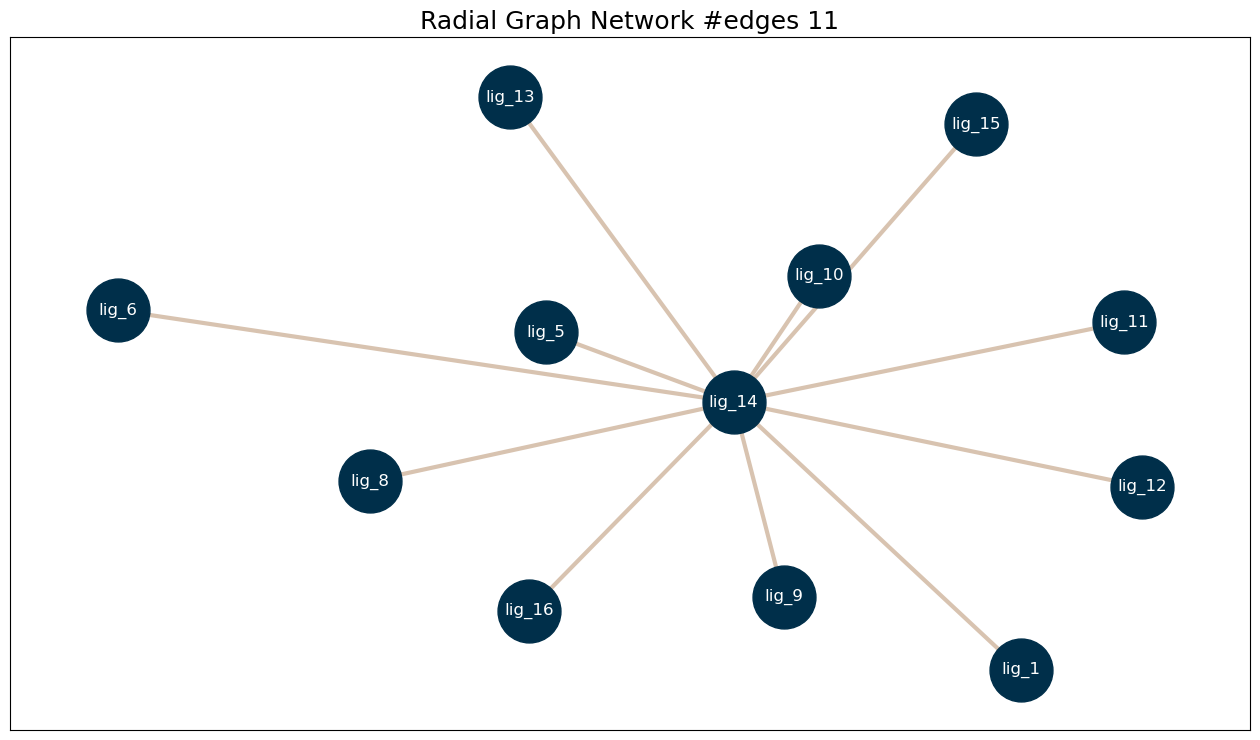

In [4]:
fig = draw_ligand_network(radial_network, title="Radial Graph");
fig.savefig(radial_network.name+"_Network.png")
fig.show()

# Minimal Spanning Tree

In [5]:
from konnektor.network_planners import MinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [6]:
mst_network = ligand_network_planner(compounds)
mst_network.name="MST"
mst_network

/tmp/ipykernel_25941/2295833610.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


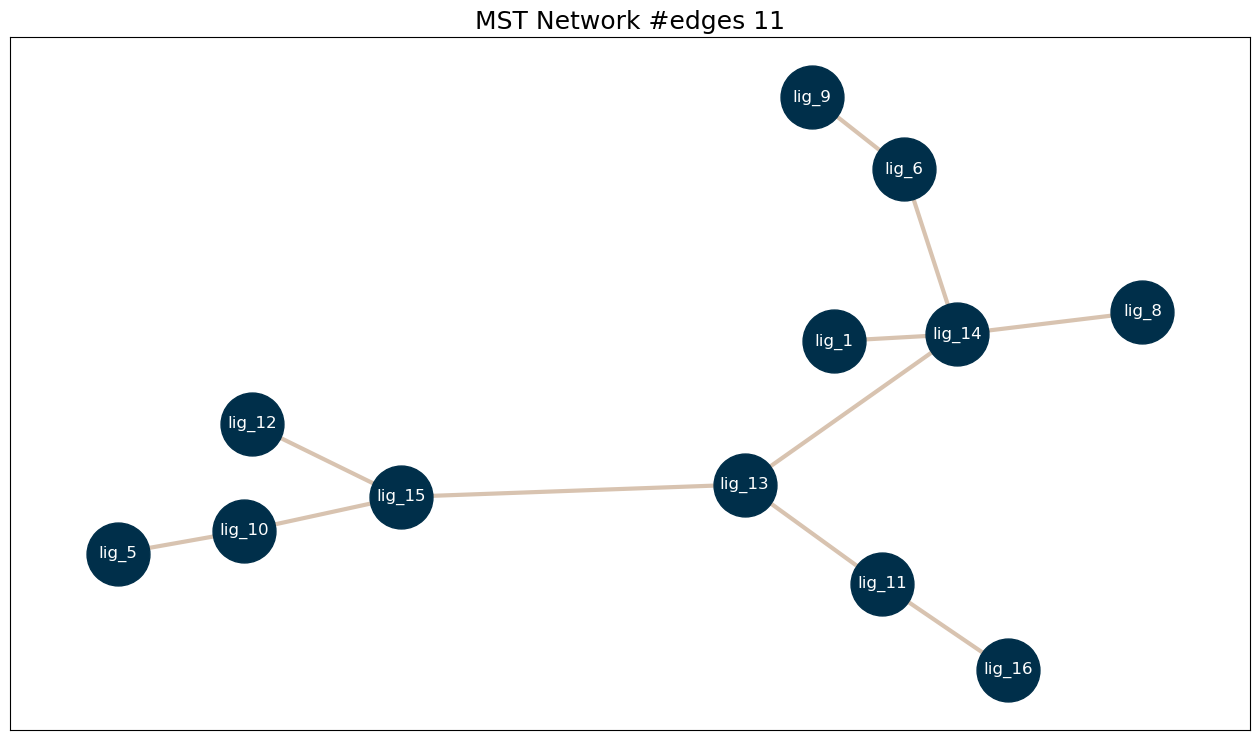

In [7]:
fig = draw_ligand_network(mst_network, "MST");
fig.savefig("MST_Network.png")
fig.show()

# Cyclo Graphs

In [8]:
from konnektor.network_planners import CyclicLigandNetworkPlanner
ligand_network_planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score,
                                                    cycle_sizes=3, node_present_in_cycles=1)

In [9]:
cyclic_network = ligand_network_planner(compounds)
cyclic_network.name="Cyclic"
cyclic_network

/tmp/ipykernel_25941/1302321791.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


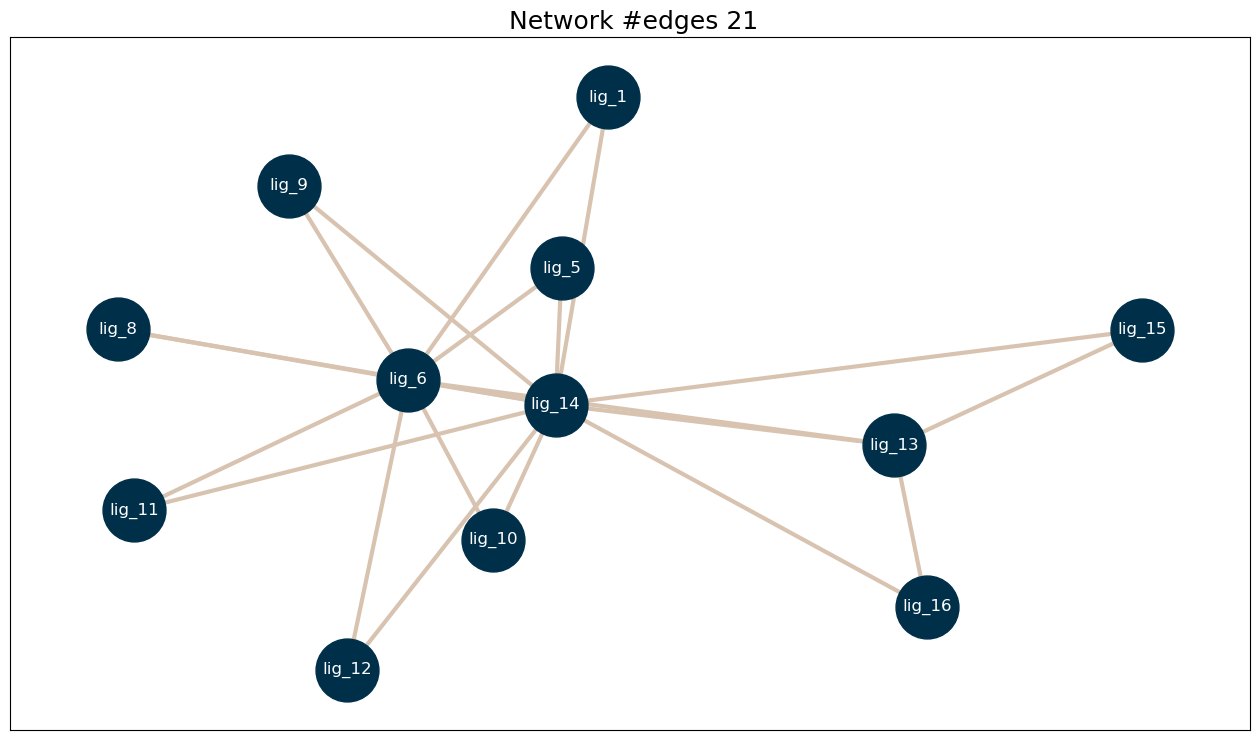

In [10]:
fig = draw_ligand_network(cyclic_network);
fig.savefig(cyclic_network.name+"_Network.png")
fig.show()

Text(0.5, 0.98, 'Algorithm I')

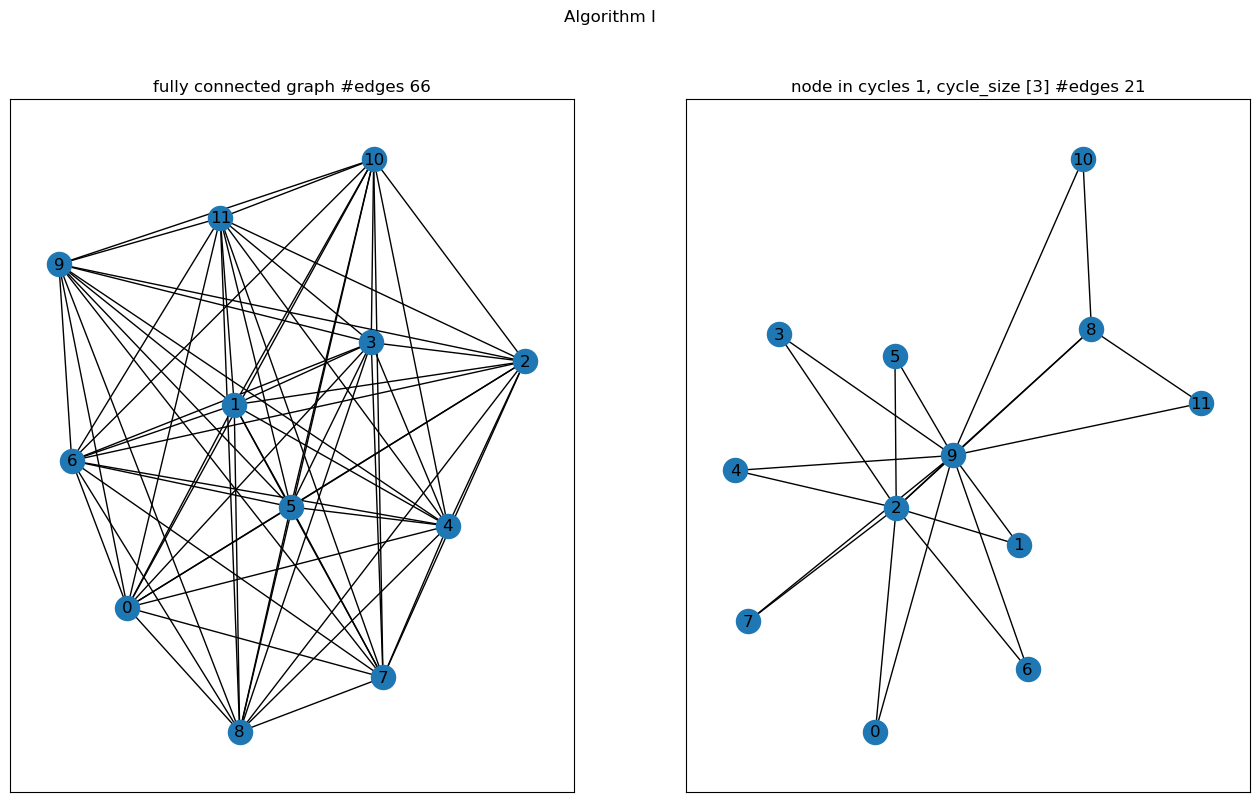

In [11]:
import networkx as nx
from matplotlib import pyplot as plt

ng=ligand_network_planner.network_generator
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[16,9])
nx.draw_networkx(ng.orig_g, with_labels=True, ax=axes[0])
nx.draw_networkx(ng.cyclic_graph, with_labels=True, ax=axes[1])


axes[0].set_title("fully connected graph"+" #edges "+str(len(ng.orig_g.edges)))
axes[1].set_title("node in cycles "+str(ng.node_cycle_connectivity)+", cycle_size "+str(ng.sub_cycle_size_range)+" #edges "+str(len(ng.cyclic_graph.edges)))
fig.suptitle("Algorithm I")

# Maximally connected network

In [12]:
from konnektor.network_planners import MaximalNetworkPlanner
ligand_network_planner = MaximalNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [13]:
max_network = ligand_network_planner(compounds)
max_network.name = "Max"
max_network

 61%|######    | 40/66 [00:01<00:00, 26.28it/s]

/tmp/ipykernel_25941/323473944.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


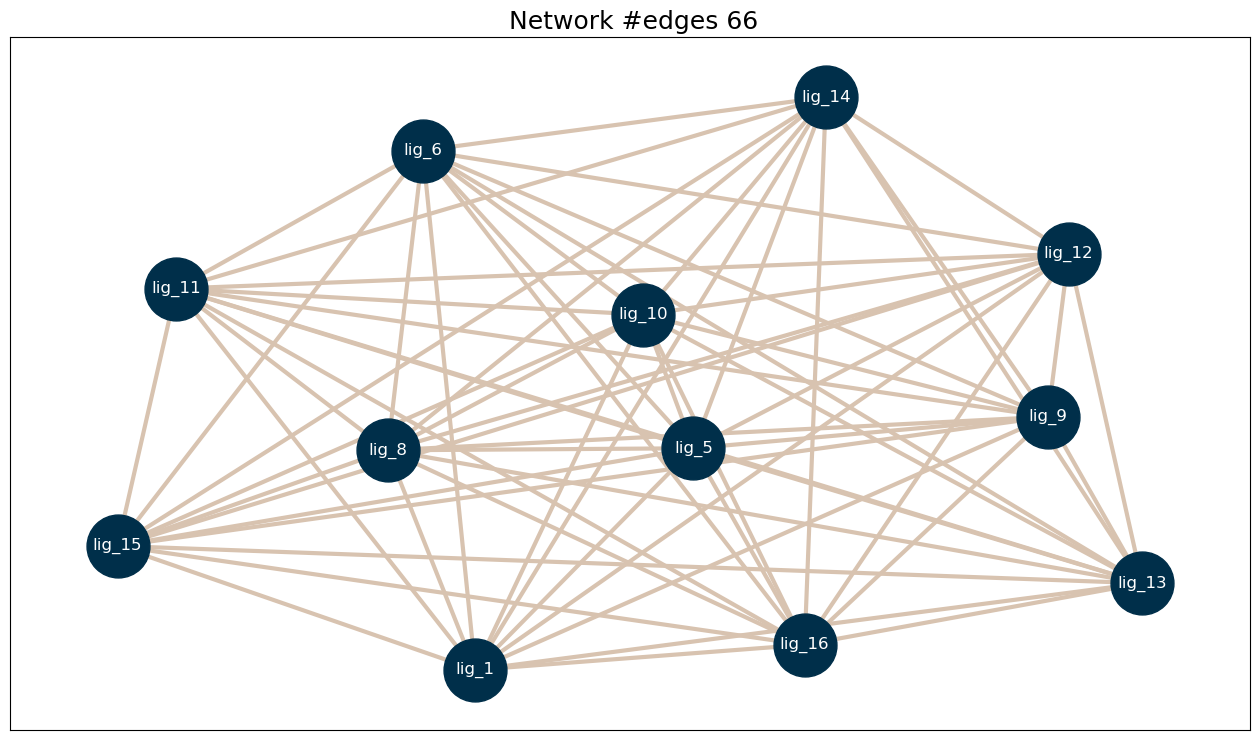

In [14]:
fig = draw_ligand_network(max_network);
fig.savefig(max_network.name+"_Network.png")
fig.show()

# Diversity Cluster Network

In [17]:
from konnektor.network_planners import DiversityNetworkPlanner
from sklearn.cluster import KMeans
ligand_network_planner = DiversityNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [18]:
div_network = ligand_network_planner(compounds)
div_network.name = "Diversity Cluster"
div_network

/home/bries/programs/miniconda3/envs/openfe/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:	Number of edges in individual networks:
22/[12, 10]
INFO:	Adding ConnectingEdges: 3
INFO:	Total Concatenating Edges: 3
INFO:	Total Concatenated Edges: 25


/home/bries/programs/miniconda3/envs/openfe/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/tmp/ipykernel_25941/3319120852.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


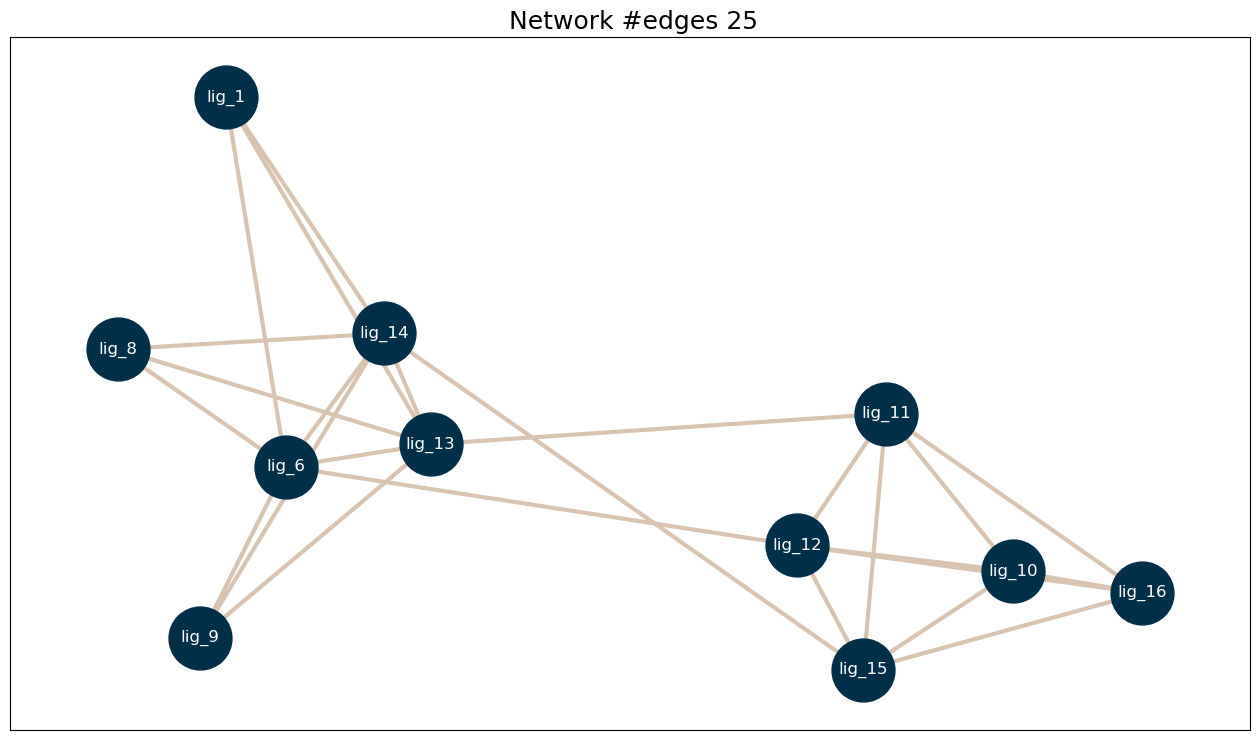

In [19]:
fig = draw_ligand_network(div_network);
fig.savefig(div_network.name+"_Network.png")
fig.show()

# Summary

(0.0, 1.0, 0.0, 1.0)

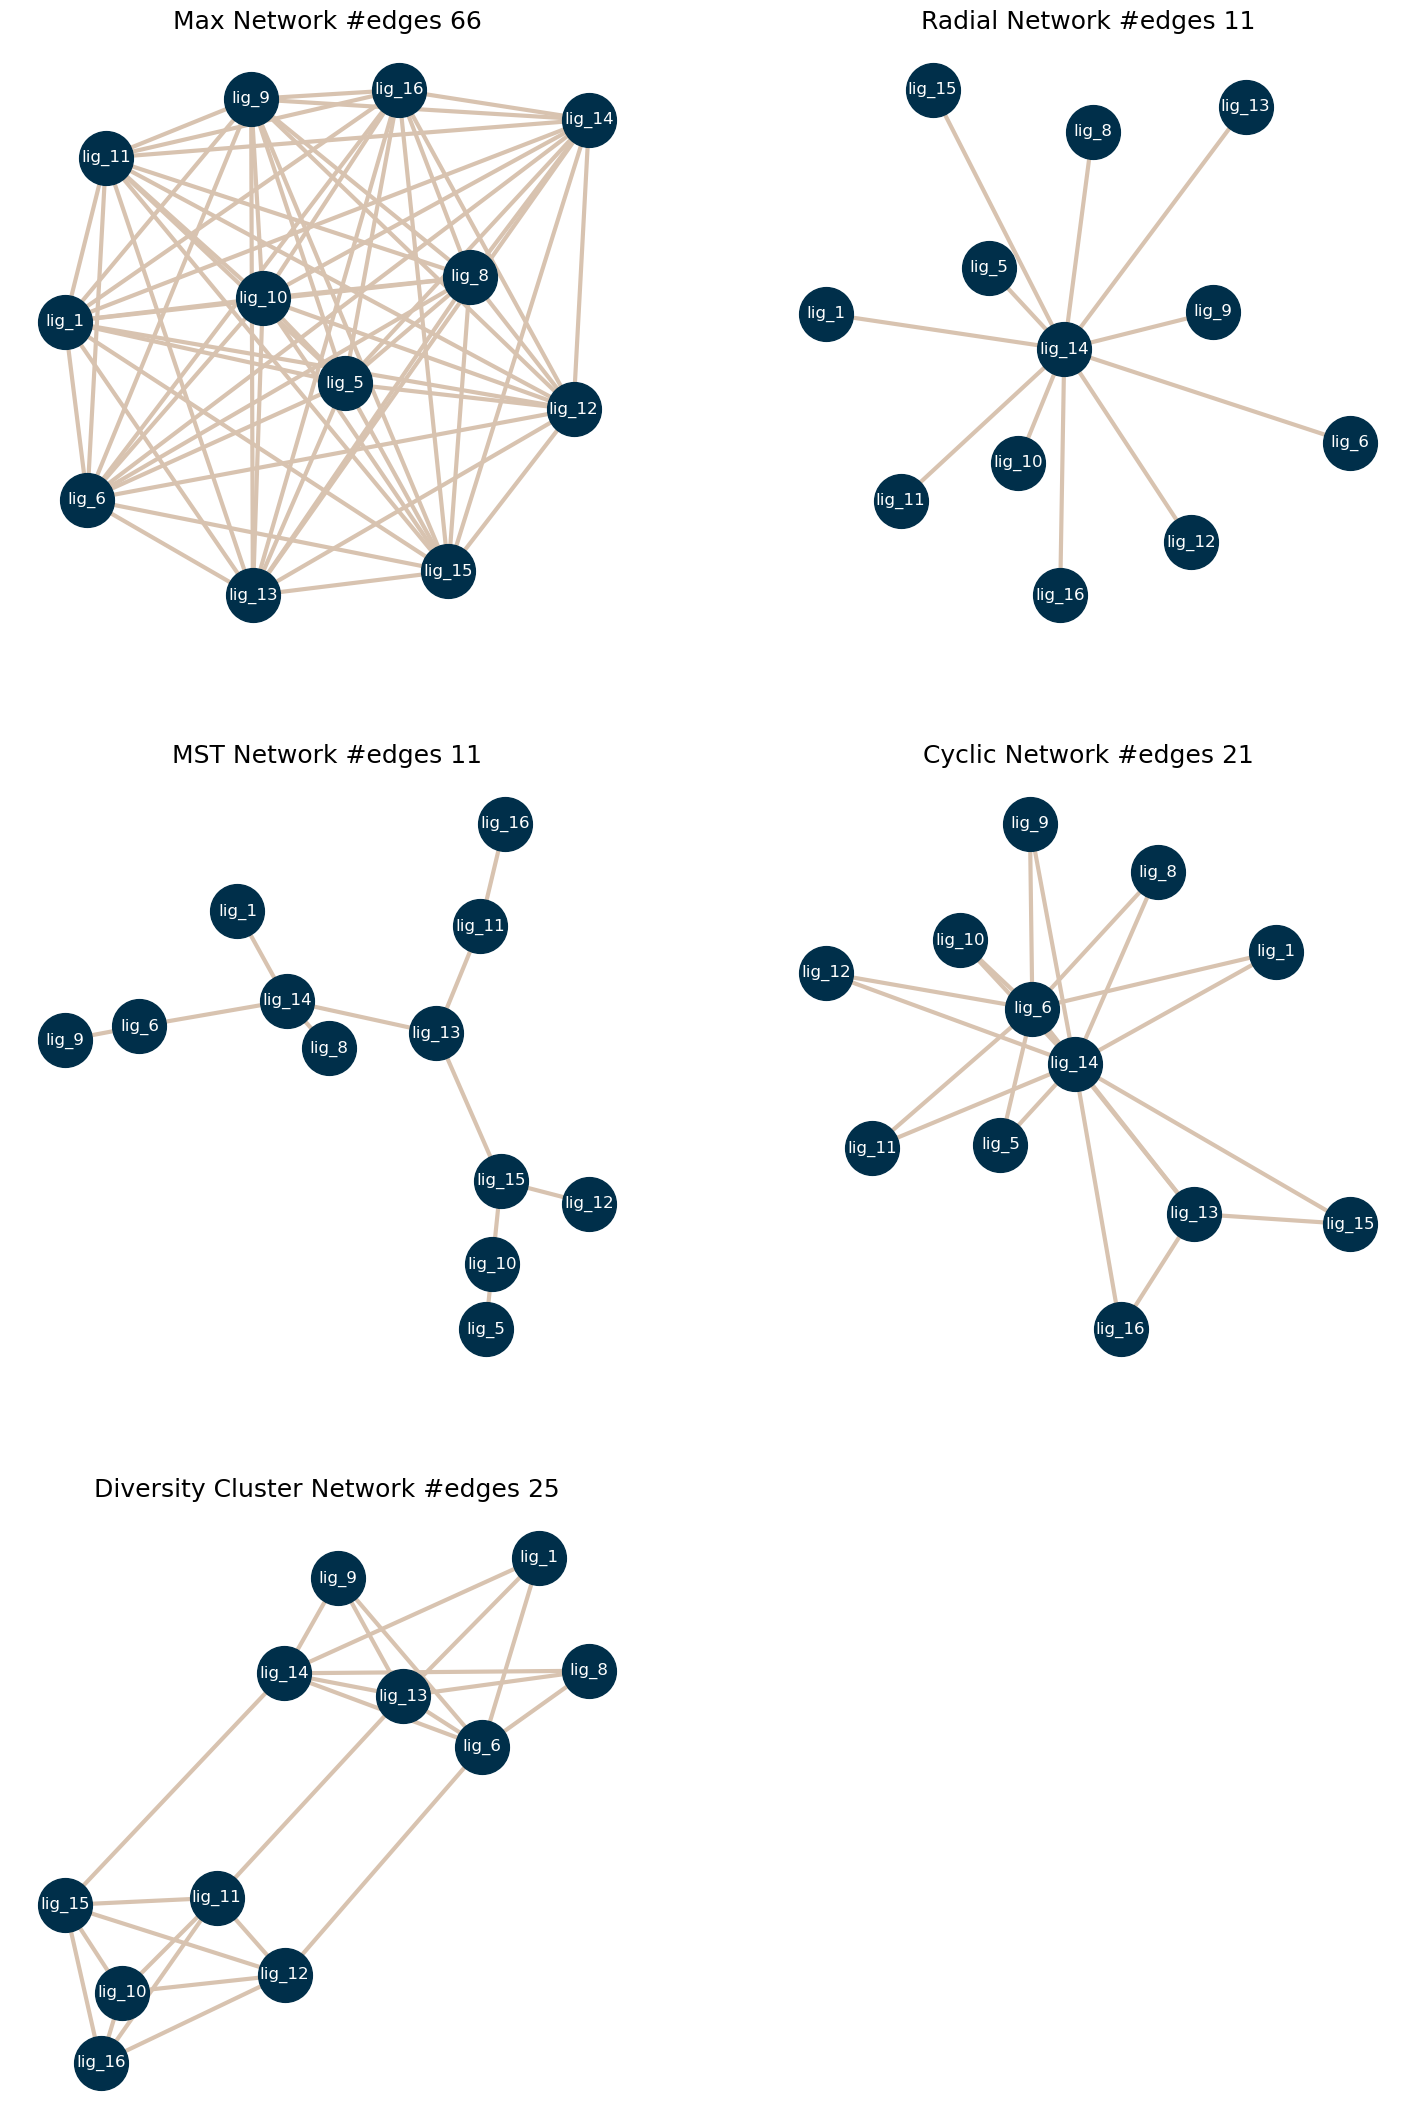

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=[9*2,3*9])
axes= np.array(axes).flat

fs = 22
for ax, net in zip(axes, [max_network, radial_network, mst_network, cyclic_network, div_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")
axes[-1].axis("off")



In [21]:
fig.savefig("../.img/network_layouts.png", dpi=400)

## in one cell:

In [ ]:
import numpy as np
from openfe_benchmarks import benzenes
from kartograf import KartografAtomMapper
from konnektor.visualization import draw_ligand_network
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score

compounds = list(filter(lambda x: not x.name in ["lig_2", "lig_3", "lig_4", "lig_7"],
                        benzenes.get_system().ligand_components))

from konnektor.network_planners import (MaximalNetworkPlanner, RadialLigandNetworkPlanner,
                                        MinimalSpanningTreeLigandNetworkPlanner, CyclicLigandNetworkPlanner)

networkers = [MaximalNetworkPlanner, RadialLigandNetworkPlanner,
              MinimalSpanningTreeLigandNetworkPlanner, CyclicLigandNetworkPlanner, DiversityNetworkPlanner]

networks = []
for networker_cls, name in zip(networkers,["Max", "Radial", "MST", "Cyclic", "Div"]):
    networker = networker_cls(mapper=KartografAtomMapper(), scorer=default_lomap_score)
    network = networker.generate_ligand_network(compounds)
    network.name=name
    networks.append(network)

#Visualize
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=[16,3*9])
axes= np.array(axes).flat
fs=22
for ax, net in zip(axes, [max_network, radial_network, mst_network, cyclic_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500, fontsize=fs)
    ax.axis("off")

axes[-1].axis("off")
fig.show()
